## Deep learning for predicting log returns for BTCUSD

In [1]:
import matplotlib.pyplot as plt

In [2]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                # Binance market data utilities

In [3]:
research.set_seed(42)

In [4]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1) #Show all colums

polars.config.Config

#### Getting Data from Binance

##### Setting the data parameters

In [5]:
#Trading pair symbol
sym = "BTCUSDT"
#Historical data window in days (e.g., 6 months)
hist_data_window = 7*4*12 #Days, weeks, months
#time horizon of time series (time interval)
time_interval = "1h"
#max number of auto-regressive lags
max_lags = 4
#Forecast horizon
forecast_horizon = 1
#Sharpe annualzied rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval,365,24)

In [6]:
# binance.download_trades(sym, hist_data_window)

In [7]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 336/336 [00:50<00:00,  6.67file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-12-07 00:00:00,99802.5,100468.9,99604.5,100339.3
2024-12-07 01:00:00,100339.3,100499.0,99902.2,100119.0
2024-12-07 02:00:00,100118.9,100240.2,99931.2,100008.1
2024-12-07 03:00:00,100008.0,100017.2,99361.0,99383.0
2024-12-07 04:00:00,99383.0,99741.0,99121.9,99570.6
…,…,…,…,…
2025-11-07 19:00:00,102551.3,103350.7,102429.4,103350.0
2025-11-07 20:00:00,103350.0,103849.9,102889.6,103718.4
2025-11-07 21:00:00,103718.4,103844.9,103295.6,103844.9


In [8]:
research.load_timeseries(sym, time_interval, pl.col("price").quantile(0.5).alias("price_median"))

Loading BTCUSDT: 100%|██████████| 336/336 [00:54<00:00,  6.18file/s]


datetime,price_median
datetime[μs],f64
2024-12-07 00:00:00,100242.2
2024-12-07 01:00:00,100193.5
2024-12-07 02:00:00,100138.8
2024-12-07 03:00:00,99564.7
2024-12-07 04:00:00,99433.9
…,…
2025-11-07 19:00:00,102876.9
2025-11-07 20:00:00,103330.0
2025-11-07 21:00:00,103430.0


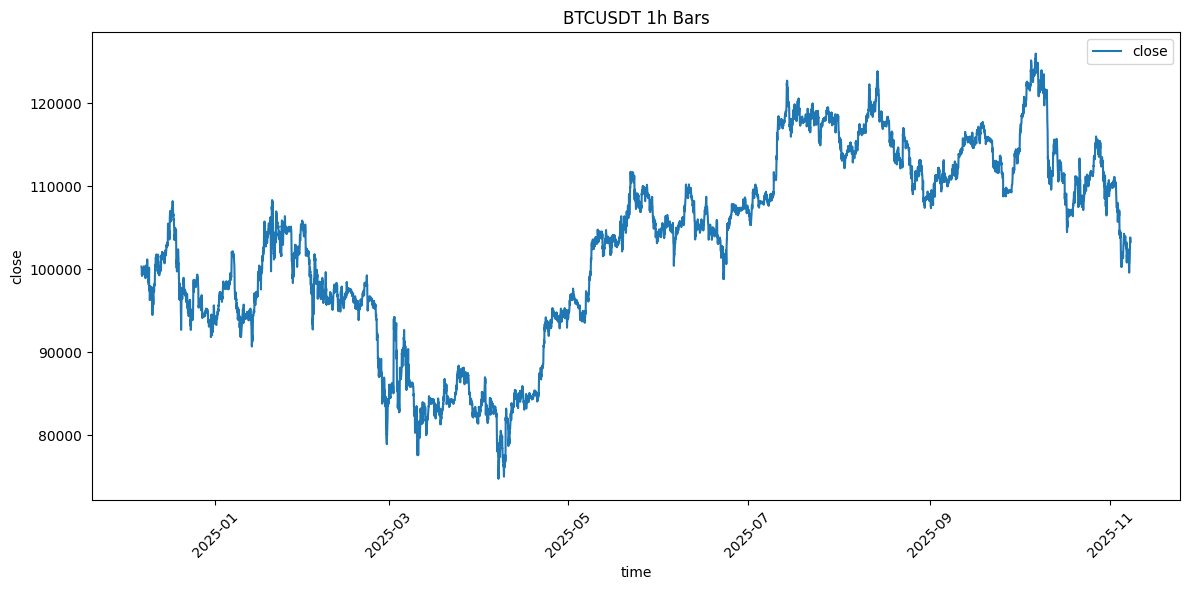

In [9]:
research.plot_static_timeseries(ts, sym, "close", time_interval)

In [10]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, "close", time_interval)

alt.Chart(...)

#### Feature Engineering

##### Understanding log returns

In [11]:
price_time_series = pl.DataFrame({"price":[100.0,120.0, 100.0]})
research.plot_column(price_time_series, "price")

alt.Chart(...)

In [12]:
price_time_series.with_columns(
    pl.col("price").diff().alias("delta"),
    ((pl.col("price")-pl.col("price").shift())/pl.col("price").shift()).alias("return"),
    (pl.col("price")/pl.col("price").shift()).log().alias("log_returns")
)

price,delta,return,log_returns
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


##### Create target and lagged features

In [13]:
ts = ts.with_columns((pl.col("close")/pl.col("close").shift(forecast_horizon)).log().alias("close_log_return"))

In [14]:
ts.head()

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2024-12-07 00:00:00,99802.5,100468.9,99604.5,100339.3,null
2024-12-07 01:00:00,100339.3,100499.0,99902.2,100119.0,-0.002198
2024-12-07 02:00:00,100118.9,100240.2,99931.2,100008.1,-0.001108
2024-12-07 03:00:00,100008.0,100017.2,99361.0,99383.0,-0.00627
2024-12-07 04:00:00,99383.0,99741.0,99121.9,99570.6,0.001886


- Creating lagged features

In [15]:
target = "close_log_return"
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon*1).alias(f"{target}_lag_1"),
    lr.shift(forecast_horizon*2).alias(f"{target}_lag_2"),
    lr.shift(forecast_horizon*3).alias(f"{target}_lag_3"),
    lr.shift(forecast_horizon*4).alias(f"{target}_lag_4"),
    )
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-12-07 00:00:00,99802.5,100468.9,99604.5,100339.3,null,null,null,null,null
2024-12-07 01:00:00,100339.3,100499.0,99902.2,100119.0,-0.002198,null,null,null,null
2024-12-07 02:00:00,100118.9,100240.2,99931.2,100008.1,-0.001108,-0.002198,null,null,null
2024-12-07 03:00:00,100008.0,100017.2,99361.0,99383.0,-0.00627,-0.001108,-0.002198,null,null
2024-12-07 04:00:00,99383.0,99741.0,99121.9,99570.6,0.001886,-0.00627,-0.001108,-0.002198,null
…,…,…,…,…,…,…,…,…,…
2025-11-07 19:00:00,102551.3,103350.7,102429.4,103350.0,0.007758,0.00192,0.012052,0.003669,0.000044
2025-11-07 20:00:00,103350.0,103849.9,102889.6,103718.4,0.003558,0.007758,0.00192,0.012052,0.003669
2025-11-07 21:00:00,103718.4,103844.9,103295.6,103844.9,0.001219,0.003558,0.007758,0.00192,0.012052


In [16]:
ts = ts.drop_nulls()

In [17]:
research.plot_distribution(ts,target, no_bins=100)

alt.Chart(...)

In [18]:
research.plot_distribution(ts, "close", no_bins=100)

alt.Chart(...)

#### Building the Machine learning model

- <p style="color:green">We should always start with a linear model. Linear model can also be profitable because the simplicity of linear models allows them to be interpretable and they will have better generalization

##### Linear Model

In [19]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)
    
    def forward(self, x):
        return self.linear(x)

- Complexity of the model

In [20]:
input_features = 1

linear_model = LinearModel(input_features)
research.print_model_info(linear_model, "LinearModel")
research.total_model_params(linear_model)


LinearModel

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

- This is essentially : <p style="color:yellow"> y = mx+c</p>

#### Split the data by time

In [21]:
features = ["close_log_return_lag_1"]
target = "close_log_return"
test_size = 0.25

In [22]:
len(ts)

8059

In [23]:
int(len(ts)*test_size)

2014

In [24]:
split_idx = int(len(ts)* (1-test_size))
split_idx

6044

In [25]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [26]:
print(len(ts_train),len(ts_test))

6044 2015


In [27]:
ts_train.head()

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-12-07 05:00:00,99570.7,99715.0,98876.9,99204.9,-0.00368,0.001886,-0.00627,-0.001108,-0.002198
2024-12-07 06:00:00,99204.9,99445.6,99117.8,99392.2,0.001886,-0.00368,0.001886,-0.00627,-0.001108
2024-12-07 07:00:00,99392.2,99550.2,99149.1,99442.6,0.000507,0.001886,-0.00368,0.001886,-0.00627
2024-12-07 08:00:00,99442.6,99630.9,99314.8,99473.4,0.00031,0.000507,0.001886,-0.00368,0.001886
2024-12-07 09:00:00,99473.3,99895.3,99467.4,99728.0,0.002556,0.00031,0.000507,0.001886,-0.00368


In [28]:
ts_test.head()

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-16 01:00:00,117696.1,117853.5,117578.4,117778.4,0.000699,0.003548,-0.003158,0.003205,0.000368
2025-08-16 02:00:00,117778.5,117778.5,117384.7,117458.8,-0.002717,0.000699,0.003548,-0.003158,0.003205
2025-08-16 03:00:00,117458.9,117619.2,117337.2,117385.0,-0.000629,-0.002717,0.000699,0.003548,-0.003158
2025-08-16 04:00:00,117385.0,117857.1,117369.6,117772.8,0.003298,-0.000629,-0.002717,0.000699,0.003548
2025-08-16 05:00:00,117772.8,117817.9,117473.5,117550.4,-0.00189,0.003298,-0.000629,-0.002717,0.000699


##### Creating the train test split

In [29]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float()

y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = ts_test[target].to_torch().float()

In [30]:
X_train

tensor([[ 0.0019],
        [-0.0037],
        [ 0.0019],
        ...,
        [ 0.0004],
        [ 0.0032],
        [-0.0032]])

In [31]:
X_train.shape

torch.Size([6044, 1])

In [32]:
y_train

tensor([-0.0037,  0.0019,  0.0005,  ...,  0.0032, -0.0032,  0.0035])

In [33]:
y_train.shape

torch.Size([6044])

In [34]:
y_train = y_train.reshape(-1,1)
y_train

tensor([[-0.0037],
        [ 0.0019],
        [ 0.0005],
        ...,
        [ 0.0032],
        [-0.0032],
        [ 0.0035]])

In [35]:
y_train.shape

torch.Size([6044, 1])

In [36]:
y_test = y_test.reshape(-1,1)
y_test

tensor([[ 0.0007],
        [-0.0027],
        [-0.0006],
        ...,
        [ 0.0012],
        [-0.0025],
        [-0.0027]])

In [37]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 0.0019],
         [-0.0037],
         [ 0.0019],
         ...,
         [ 0.0004],
         [ 0.0032],
         [-0.0032]]),
 tensor([[ 0.0035],
         [ 0.0007],
         [-0.0027],
         ...,
         [ 0.0036],
         [ 0.0012],
         [-0.0025]]),
 tensor([[-0.0037],
         [ 0.0019],
         [ 0.0005],
         ...,
         [ 0.0032],
         [-0.0032],
         [ 0.0035]]),
 tensor([[ 0.0007],
         [-0.0027],
         [-0.0006],
         ...,
         [ 0.0012],
         [-0.0025],
         [-0.0027]]))

#### Batch Gradient Descent

<p style="color:yellow">Hyperparameters</p>

In [38]:
no_epochs = 1000 * 5
lr = 0.0005 #learning rate

<p style="color: yellow">Creating the model</p>

In [39]:
model = LinearModel(len(features))
#loss function
criterion = nn.MSELoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
print("\n Training the model...")


 Training the model...


In [40]:
for epoch in range(no_epochs):
    #Forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    #backward pass
    optimizer.zero_grad()   #1. Clear old gradients
    loss.backward()         #2. Compute new gradients 
    optimizer.step()        #3. Update weights
    
    #Check for improvement
    train_loss = loss.item()

    #logging
    if (epoch +1 )%500==0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}\n{param.data.numpy()}")

#Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train loss: {train_loss:.6f}")

Epoch [500/5000], Loss: 0.468926
Epoch [1000/5000], Loss: 0.234669
Epoch [1500/5000], Loss: 0.101769
Epoch [2000/5000], Loss: 0.036166
Epoch [2500/5000], Loss: 0.009762
Epoch [3000/5000], Loss: 0.001823
Epoch [3500/5000], Loss: 0.000226
Epoch [4000/5000], Loss: 0.000037
Epoch [4500/5000], Loss: 0.000025
Epoch [5000/5000], Loss: 0.000025

Learned parameters
linear.weight
[[-0.02497482]]
linear.bias
[7.5672986e-05]

Test Loss: 0.000016, Train loss: 0.000025


#### Hyperparameter tuning

##### Manual hyperparameter tuning

In [41]:
# # Hyperparameter grid
# # -------------------------------
# learning_rates = [0.01, 0.001, 0.0005]
# weight_decays = [0, 1e-4, 1e-5]
# optimizers = ['adam', 'sgd']

# no_epochs = 5000

# # Storage for results
# all_histories = {}    # { (lr, wd, opt): {'train': [...], 'test': [...]} }
# test_results = {}     # { (lr, wd, opt): final_test_loss }


In [42]:
# # -------------------------------
# # Hyperparameter tuning loop
# # -------------------------------
# for lr in learning_rates:
#     for wd in weight_decays:
#         for opt in optimizers:
#             model = LinearModel(len(features))
#             criterion = nn.MSELoss()
            
#             # Choose optimizer
#             if opt == 'adam':
#                 optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
#             else:
#                 optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
            
#             # Track per-epoch losses
#             train_losses = []
#             test_losses = []

#             for epoch in range(no_epochs):
#                 model.train()
#                 y_hat = model(X_train)
#                 loss = criterion(y_hat, y_train)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 # Evaluate on test data periodically (every 10 epochs)
#                 if (epoch + 1) % 10 == 0:
#                     model.eval()
#                     with torch.no_grad():
#                         y_hat_test = model(X_test)
#                         test_loss = criterion(y_hat_test, y_test)
#                         test_losses.append(test_loss.item())
#                 else:
#                     test_losses.append(None)  # placeholder for alignment
                
#                 train_losses.append(loss.item())

#             # Save histories
#             all_histories[(lr, wd, opt)] = {'train': train_losses, 'test': test_losses}
            
#             # Final test evaluation
#             model.eval()
#             with torch.no_grad():
#                 y_hat_test = model(X_test)
#                 final_test_loss = criterion(y_hat_test, y_test)
            
#             test_results[(lr, wd, opt)] = final_test_loss.item()
#             print(f"Finished: lr={lr}, wd={wd}, opt={opt}, Final Test Loss={final_test_loss.item():.6f}")


In [43]:
# plt.figure(figsize=(10,6))
# for (lr, wd, opt), history in all_histories.items():
#     label = f"lr={lr}, wd={wd}, opt={opt}"
#     plt.plot(history['train'], label=label)

# plt.title("Training Loss Curves for Different Hyperparameters")
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.grid(True)
# plt.show()


#### Test Trade perfomance

In [44]:
trade_results = pl.DataFrame({
    'y_hat':y_hat.squeeze(),
    'y':y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias("trade_log_returns")
).with_columns(
    pl.col("trade_log_returns").cum_sum().alias("equity_curve")
)

In [45]:
trade_results

y_hat,y,is_won,signal,trade_log_returns,equity_curve
f32,f32,bool,f32,f32,f32
-0.000013,0.000699,false,-1.0,-0.000699,-0.000699
0.000058,-0.002717,false,1.0,-0.002717,-0.003416
0.000144,-0.000629,false,1.0,-0.000629,-0.004045
0.000091,0.003298,true,1.0,0.003298,-0.000747
-0.000007,-0.00189,true,-1.0,0.00189,0.001144
…,…,…,…,…,…
0.000028,0.007758,true,1.0,0.007758,-0.046812
-0.000118,0.003558,false,-1.0,-0.003558,-0.050371
-0.000013,0.001219,false,-1.0,-0.001219,-0.05159


- Our model is simple linear regression trying to predict future log returns from past log returns
- y_test contains actual historical log returns — the ground truth of what happened in the market over your forecast horizon.

Our approach above is this - 

    - Using predictions to decide direction (long/short)
    - Measuring performance against actual market moves
    - Working in log return space throughout

In [46]:
research.plot_column(trade_results,"equity_curve")

alt.Chart(...)

#### Equity curve metrics

##### Drawdown

In [47]:
trade_results = trade_results.with_columns(
    (pl.col("equity_curve")-pl.col("equity_curve").cum_max()).alias("drawdown_log")
)
trade_results

y_hat,y,is_won,signal,trade_log_returns,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
-0.000013,0.000699,false,-1.0,-0.000699,-0.000699,0.0
0.000058,-0.002717,false,1.0,-0.002717,-0.003416,-0.002717
0.000144,-0.000629,false,1.0,-0.000629,-0.004045,-0.003346
0.000091,0.003298,true,1.0,0.003298,-0.000747,-0.000048
-0.000007,-0.00189,true,-1.0,0.00189,0.001144,0.0
…,…,…,…,…,…,…
0.000028,0.007758,true,1.0,0.007758,-0.046812,-0.089763
-0.000118,0.003558,false,-1.0,-0.003558,-0.050371,-0.093322
-0.000013,0.001219,false,-1.0,-0.001219,-0.05159,-0.094541


In [48]:
max_drawdonw_log = trade_results["drawdown_log"].min()
max_drawdonw_log

-0.15804845094680786

In [49]:
drawdown_pct = np.exp(max_drawdonw_log)-1
drawdown_pct

np.float64(-0.1461915868596988)

In [62]:
example_equity_peak = 1000
example_equity_peak * drawdown_pct

np.float64(-146.1915868596988)

In [63]:
win_rate = trade_results["is_won"].mean()
win_rate

0.49627791563275436

In [64]:
avg_win = trade_results.filter(pl.col("is_won")==True)["trade_log_returns"].mean()
avg_loss = trade_results.filter(pl.col("is_won")==False)["trade_log_returns"].mean()
expected_value = win_rate * avg_win * (1-win_rate) * avg_loss
expected_value

-1.7266907981878086e-06

In [65]:
total_log_return = trade_results["trade_log_returns"].sum()
total_log_return

-0.05680033937096596

In [66]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(0.9447826864416702)

In [67]:
1000*compound_return

np.float64(944.7826864416702)

In [68]:
equity_troff = trade_results["equity_curve"].min()
equity_troff

-0.11509747803211212

In [ ]:
equity_peak = trade_results["equity_curve"].max()
equity_peak

0.04295097663998604

In [73]:
std = trade_results["trade_log_returns"].std()
std

0.003938747104257345

In [75]:
sharpe = expected_value / std * annualized_rate
sharpe

np.float64(-0.04103066263597032)

In [77]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 2015,
 'win_rate': 0.49627791563275436,
 'avg_win': 0.0026195348243575156,
 'avg_loss': -0.002636783406158904,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.024077938869595528,
 'ev': -2.8188750815767586e-05,
 'std': 0.003938747104257345,
 'total_log_return': -0.05680033937096596,
 'compound_return': np.float64(0.9447826864416702),
 'max_drawdown': -0.15804845094680786,
 'equity_trough': -0.11509747803211212,
 'equity_peak': 0.04295097663998604,
 'sharpe': np.float64(-0.6698380080933283)}

#### Exploring Other Features